## Basic Model used for Simplified Stats dataset

In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

class BoreholeDataset(Dataset):
    def __init__(self, csv_file, length_scaler, CPTu_scaler, output_scaler, fit_scalers=True):
        data = pd.read_csv(csv_file)
        self.inputs = data.iloc[:, 0].values.reshape(-1, 1)
        self.CPTu = data.iloc[:, 1:8].values
        self.outputs = data.iloc[:, 8].values.reshape(-1, 1)

        if fit_scalers:
            self.input_data = length_scaler.fit_transform(self.inputs)
            self.CPTu_data = CPTu_scaler.fit_transform(self.CPTu)
            self.outputs = output_scaler.fit_transform(self.outputs)
        else:
            self.input_data = length_scaler.transform(self.inputs)
            self.CPTu_data = CPTu_scaler.transform(self.CPTu)
            self.outputs = output_scaler.transform(self.outputs)

        self.inputs = torch.tensor(self.input_data, dtype=torch.float32)
        self.CPTu = torch.tensor(self.CPTu_data, dtype=torch.float32)
        self.outputs = torch.tensor(self.outputs, dtype=torch.float32)

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.CPTu[idx], self.outputs[idx]

length_scaler = StandardScaler()
CPTu_scaler = StandardScaler()
output_scaler = StandardScaler()

train_dataset = BoreholeDataset('Stage_1_traind_stats_merged2.csv', length_scaler, CPTu_scaler, output_scaler, True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = BoreholeDataset('Stage_1_vald_stats_merged2.csv', length_scaler, CPTu_scaler, output_scaler, False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def relative_error(outputs, targets):
    with torch.no_grad():
        epsilon = 1e-8
        rel_error = 100 * (torch.abs(outputs - targets) / (torch.abs(targets) + epsilon))
        return rel_error.mean().item()

class TwoBranchMLP(nn.Module):
    def __init__(self):
        super(TwoBranchMLP, self).__init__()
        self.length_branch = nn.Sequential(
            nn.Linear(1, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.cptu_branch = nn.Sequential(
            nn.Linear(7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        self.attention = nn.Sequential(
            nn.Linear(1536, 1536),  # Same as combined features count
            nn.Tanh(),
            nn.Softmax(dim=1)
        )
        self.output = nn.Sequential(
            nn.Linear(1536, 512),  # Same as combined after attention application
            nn.LeakyReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, length, cptu):
        length_out = self.length_branch(length)
        cptu_out = self.cptu_branch(cptu)
        combined = torch.cat((length_out, cptu_out), dim=1)

        # Apply attention
        # attention_weights = self.attention(combined)
        # combined = combined * attention_weights  # Element-wise multiplication

        # Output computation
        return self.output(combined)

# Training and other components remain the same



def train_model(model, optimizer, criterion, train_loader, val_loader, epochs, scheduler=None):
    train_errors, val_errors = [], []
    train_r2_scores, val_r2_scores = [], []
    train_relative_errors, val_relative_errors = [], []

    for epoch in range(epochs):
        model.train()
        batch_train_errors = []
        predictions_train_list, targets_train_list = [], []
        total_train_loss = 0

        for length, CPTu, outputs in train_loader:
            optimizer.zero_grad()
            predictions = model(length, CPTu)
            loss = criterion(predictions, outputs)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions_train_list.extend(predictions.detach().cpu().numpy())
            targets_train_list.extend(outputs.detach().cpu().numpy())

            batch_train_error = relative_error(predictions.detach(), outputs.detach())
            batch_train_errors.append(batch_train_error)

        train_r2 = r2_score(targets_train_list, predictions_train_list)
        train_r2_scores.append(train_r2)
        train_errors.append(total_train_loss / len(train_loader))
        train_relative_errors.append(np.mean(batch_train_errors))

        model.eval()
        batch_val_errors = []
        predictions_val_list, targets_val_list = [], []
        total_val_loss = 0

        with torch.no_grad():
            for length, CPTu, outputs in val_loader:
                predictions = model(length, CPTu)
                val_loss = criterion(predictions, outputs)
                total_val_loss += val_loss.item()

                predictions_val_list.extend(predictions.cpu().numpy())
                targets_val_list.extend(outputs.cpu().numpy())

                val_batch_error = relative_error(predictions, outputs)
                batch_val_errors.append(val_batch_error)

        val_r2 = r2_score(targets_val_list, predictions_val_list)
        val_r2_scores.append(val_r2)
        val_errors.append(total_val_loss / len(val_loader))
        val_relative_errors.append(np.mean(batch_val_errors))

        if scheduler:
            scheduler.step()

        print(f'Epoch {epoch+1}: Train Loss: {train_errors[-1]:.4f}, Val Loss: {val_errors[-1]:.4f}, Train R2: {train_r2_scores[-1]:.4f}, Val R2: {val_r2_scores[-1]:.4f}')
        print(f'Train Rel Error (%): {train_relative_errors[-1]:.2f}%, Val Rel Error (%): {val_relative_errors[-1]:.2f}%')

    return train_errors, val_errors, train_r2_scores, val_r2_scores, train_relative_errors, val_relative_errors

model = TwoBranchMLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)  
loss_function = nn.MSELoss()

# Train the model for 5000 epochs
loss_history1 = train_model(model, optimizer, loss_function, train_loader, val_loader, epochs=1, scheduler=scheduler)


# # Saving the model's state dictionary
# torch.save(model.state_dict(), "S5_model4.pth")
# 
# # Writing the loss history to a file
# with open('S5_loss4.txt', 'w') as file:
#     for item in loss_history1:
#         file.write(f"{item}\n")
# 
# # Using joblib to dump the scalers
# from joblib import dump
# # Ensuring that the scalers are saved in a tuple format
# dump((length_scaler, CPTu_scaler, output_scaler), 'S5_scalers4.joblib')



torch.save(model, 'Stage_5_Model_26.pth')

Epoch 1: Train Loss: 0.2943, Val Loss: 0.1245, Train R2: 0.7062, Val R2: 0.8475
Train Rel Error (%): 130.07%, Val Rel Error (%): 54.20%


## Plotting Losses from HPC

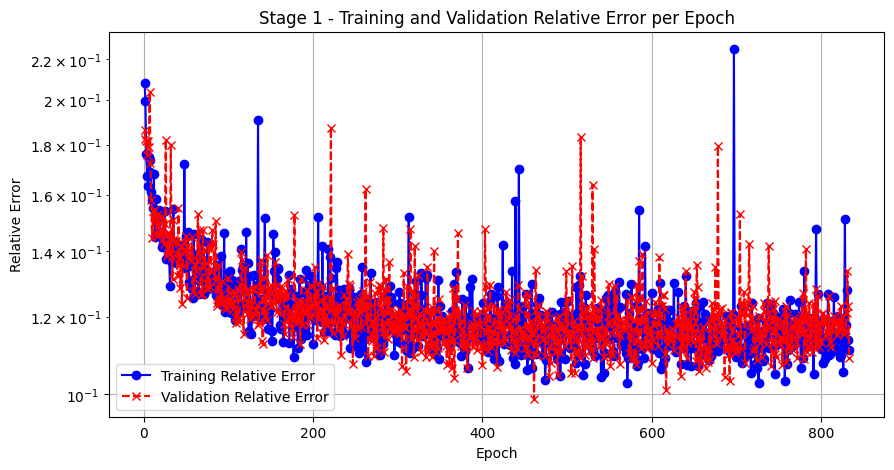

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the text file
file_path = 'S5_loss25.txt'

# Read the entire file into a single string
with open(file_path, 'r') as file:
    line = file.readline().strip()

# Remove the brackets and split the string into a list of numbers
cleaned_line = line.strip('[]')
numbers = list(map(float, cleaned_line.split(',')))

# Assuming alternate entries for training and validation losses
train_losses = numbers[5::6]  # Extract even index elements: training losses
val_losses = numbers[6::6]  # Extract odd index elements: validation losses

# Epochs array based on the shorter of the two lists
epochs = np.arange(1, min(len(train_losses), len(val_losses)) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Relative Error')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Relative Error')
plt.title('Stage 1 - Training and Validation Relative Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Relative Error')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


## Testing model for Absolute Error on Training, Validation and Testing Sets

Batch 0:
[tensor([[ 1.5054],
        [-0.7059],
        [-0.4731],
        [-0.3276],
        [-1.2150],
        [-1.0550],
        [ 1.4326],
        [ 2.0727],
        [ 0.0652],
        [-0.1240],
        [ 1.5636],
        [-1.3750],
        [-0.8077],
        [-1.0550],
        [ 1.3744],
        [ 0.6034],
        [-0.9968],
        [ 1.0398],
        [ 1.8981],
        [ 0.8071],
        [ 1.6363],
        [-0.9095],
        [-0.7641],
        [-0.9386],
        [ 1.0398],
        [-0.5749],
        [-1.3750],
        [-1.2587],
        [-1.1423],
        [-0.5022],
        [ 2.5819],
        [-0.6913]]), tensor([[ 0.8362, -0.4323, -0.2791, -0.7729, -0.9005, -0.4793, -0.3736],
        [-1.8165,  3.9005,  4.1427,  2.3829,  1.9631, -0.3284, -0.3636],
        [ 0.0289, -0.4971, -0.3631, -0.6541, -0.0424,  3.0620,  3.6871],
        [ 0.0289, -0.4971, -0.3631, -0.6541, -0.0424,  3.0620,  3.6871],
        [-2.2000,  2.9204,  2.5761,  2.3123,  1.9389, -0.1485, -0.3272],
        [-0.012

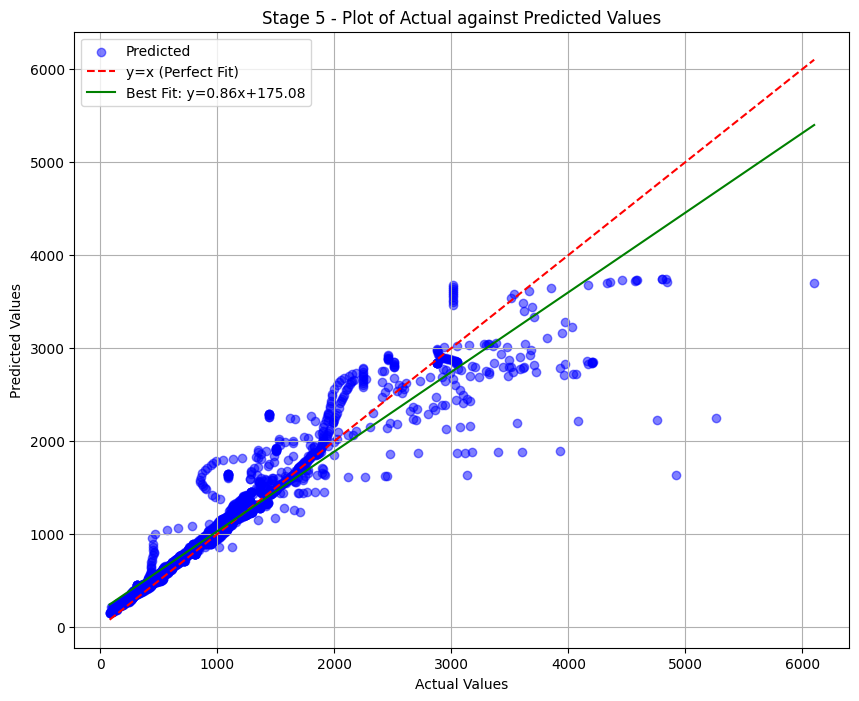

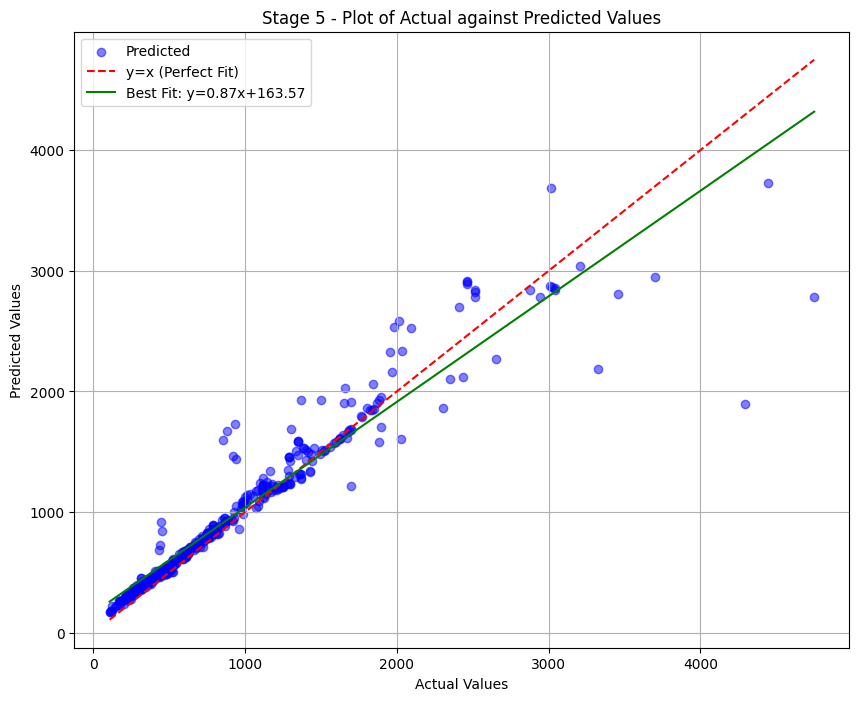

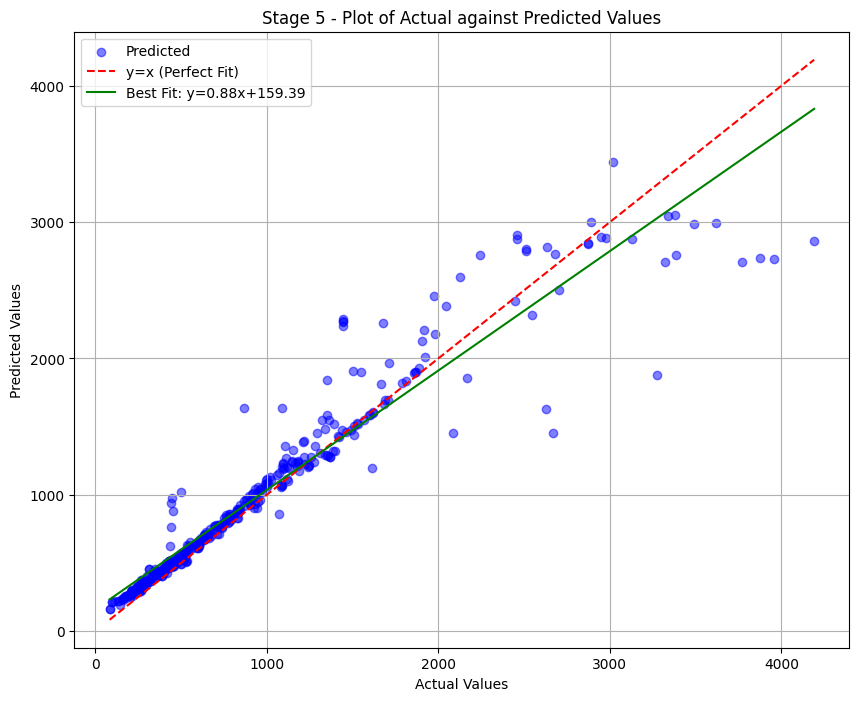

Training MSE: 61098.5930, R²: 0.9079, Relative Error: 14.6495
Validation MSE: 54351.6163, R²: 0.8997, Relative Error: 15.2536
Testing MSE: 54366.1838, R²: 0.9076, Relative Error: 16.5299


In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

model = torch.load('Stage_5_Model_25.pth')
model.load_state_dict(torch.load('S5_model25.pth'))

model.eval()

input_scaler, CPTu_scaler, output_scaler= load('S5_scalers25.joblib')

def process_data(csv_file, length_scaler, CPTu_scaler, output_scaler):
    data = pd.read_csv(csv_file)
    length = torch.tensor(length_scaler.transform(data.iloc[:, 0].values.reshape(-1, 1)), dtype=torch.float32)   
    CPTu = torch.tensor(CPTu_scaler.transform(data.iloc[:, 1:8].values), dtype=torch.float32)
    targets = torch.tensor(output_scaler.transform(data.iloc[:, 8].values.reshape(-1, 1)), dtype=torch.float32)
    
    return DataLoader(TensorDataset(length, CPTu, targets), batch_size=32, shuffle=False)

# Load your datasets
train_loader = process_data('Stage_1_traind_stats_merged2.csv', length_scaler, CPTu_scaler, output_scaler)
val_loader = process_data('Stage_1_vald_stats_merged2.csv', length_scaler, CPTu_scaler, output_scaler)
test_loader = process_data('Stage_1_testd_stats_merged2.csv', length_scaler, CPTu_scaler, output_scaler)


# Loop through the DataLoader and print the content
for i, batch in enumerate(train_loader):
    print(f"Batch {i}:")
    print(batch)
    # Optionally, add a break to only print the first few batches
    if i >= 1:  # Adjust this number based on how many batches you want to inspect
        break



def plot_actual_vs_predicted(filename, actuals, predictions, title='Actual vs. Predicted', actual_scaler=None, prediction_scaler=None):
    # If scalers are provided, inverse transform the data
    if actual_scaler is not None:
        actuals = actual_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    if prediction_scaler is not None:
        predictions = prediction_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Flatten arrays to ensure they are 1D
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Create a scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Predicted')

    # Plot the identity line
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Fit)')

    # Calculate the line of best fit
    coefficients = np.polyfit(actuals, predictions, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(np.linspace(min_val, max_val, 100))
    plt.plot(np.linspace(min_val, max_val, 100), trendline, 'g-', label=f'Best Fit: y={coefficients[0]:.2f}x+{coefficients[1]:.2f}')

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Stage 5 - Plot of Actual against Predicted Values')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()



def evaluate_model(file_name, data_loader, output_scaler):
    total_mse = 0
    total_samples = 0
    preds, actuals = [], []
    relative_errors = []

    with torch.no_grad():
        for length, CPTu, targets in data_loader:
            outputs = model(length, CPTu)

            # Inverse transform the outputs and targets for MSE and relative error calculations
            outputs_numpy = outputs.detach().cpu().numpy()  # Ensure it's a numpy array
            targets_numpy = targets.detach().cpu().numpy()
            outputs_rescaled = output_scaler.inverse_transform(outputs_numpy)
            targets_rescaled = output_scaler.inverse_transform(targets_numpy)

            # Compute MSE on rescaled data
            mse = mean_squared_error(targets_rescaled, outputs_rescaled)
            total_mse += mse * length.size(0)
            total_samples += length.size(0)

            preds.append(outputs_rescaled)
            actuals.append(targets_rescaled)

            # Compute relative error on rescaled data
            valid_indices = targets_rescaled != 0
            valid_targets = targets_rescaled[valid_indices]
            valid_outputs = outputs_rescaled[valid_indices]
            if valid_targets.size > 0:
                rel_error = np.abs((valid_targets - valid_outputs) / valid_targets)
                relative_errors.extend(rel_error)

    all_preds = np.concatenate(preds)
    all_actuals = np.concatenate(actuals)

    plot_actual_vs_predicted(file_name, all_actuals, all_preds, 'Actual vs. Predicted')

    # Calculate total MSE
    total_mse /= total_samples

    # Calculate R² score on scaled data
    r2 = r2_score(all_actuals, all_preds)

    # Calculate mean relative error on scaled data
    mean_relative_error = np.mean(relative_errors) if relative_errors else np.inf

    return total_mse, r2, mean_relative_error


# Evaluate the model using separate scaling for MSE
train_mse, train_r2, train_rel_error = evaluate_model('S5_training_actual_pred_vals', train_loader, output_scaler)
val_mse, val_r2, val_rel_error = evaluate_model('S5_validating_actual_pred_vals', val_loader, output_scaler)
test_mse, test_r2, test_rel_error = evaluate_model('S5_testing_actual_pred_vals', test_loader, output_scaler)

print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}, Relative Error: {train_rel_error*100:.4f}")
print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}, Relative Error: {val_rel_error*100:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}, Relative Error: {test_rel_error*100:.4f}")


# To access the final model weights after evaluation:
final_weights = model.state_dict()  # This dictionary holds all weights
# You can save these weights or print t


## Analysing Values from my model

Importances: [ 48657.023 390759.34  601378.06  362737.3   554527.2   448423.7
 201446.33   81136.5  ]


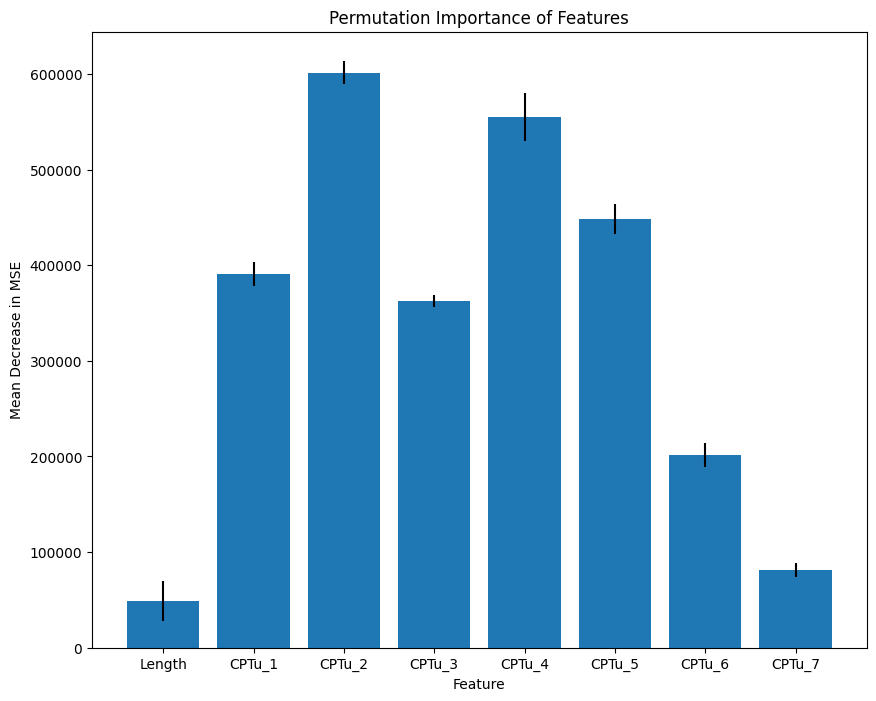

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

# Wrapper class for the PyTorch model to make it compatible with sklearn
class SklearnWrapper:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def fit(self, X, y):
        pass  # No fitting needed
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            length = torch.tensor(X[:, :1], dtype=torch.float32)
            cptu = torch.tensor(X[:, 1:], dtype=torch.float32)
            pred = self.model(length, cptu)
            pred_rescaled = self.scaler.inverse_transform(pred.numpy()).flatten()
        return pred_rescaled

def compute_permutation_importance(model, loader, scaler):
    model.eval()  # Ensure the model is in evaluation mode
    actuals = []
    predictions = []
    all_inputs = []

    # Gather actual and predicted values over the entire dataset
    with torch.no_grad():
        for length, CPTu, targets in loader:
            outputs = model(length, CPTu)
            actuals.extend(targets.numpy())
            predicted = scaler.inverse_transform(outputs.numpy())
            predictions.extend(predicted)
            # Concatenate inputs for each batch
            all_inputs.append(np.hstack([length.numpy(), CPTu.numpy()]))

    actuals = np.array(actuals).flatten()
    predictions = np.array(predictions).flatten()
    all_inputs = np.vstack(all_inputs)  # Stack all inputs vertically

    # Define a custom scoring function
    def mse_score(estimator, X, y):
        pred_rescaled = estimator.predict(X)
        return mean_squared_error(y, pred_rescaled)

    sklearn_model = SklearnWrapper(model, scaler)
    result = permutation_importance(sklearn_model, all_inputs, actuals, scoring=mse_score, n_repeats=10, random_state=42)

    return result

# Example usage
result = compute_permutation_importance(model, train_loader, output_scaler)
print("Importances:", result.importances_mean)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(result.importances_mean)), result.importances_mean, yerr=result.importances_std)
plt.xticks(range(len(result.importances_mean)), ['Length'] + [f'CPTu_{i}' for i in range(1, 8)])
plt.title('Permutation Importance of Features')
plt.ylabel('Mean Decrease in MSE')
plt.xlabel('Feature')
# plt.legend()
plt.savefig('Stage_5_Sensitivity_Analysis.png', dpi=300)
plt.show()
